In [1]:
# common.py  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from joblib import dump
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_and_preprocess_data(merge_features_path, merged_data_path):
    features = pd.read_csv(merge_features_path)
    traits = pd.read_csv(merged_data_path)
    data = pd.merge(traits, features, on='ID', how='inner')
    data = data.drop(columns=['ID'])
    
    target_cols = features.columns.difference(traits.columns).tolist()
    target_cols = [col for col in target_cols if col != 'ID']
    X = data.drop(columns=target_cols)
    y = data[target_cols]
    return X, y, target_cols

def create_preprocessing_pipeline(n_features, k_best=None, use_pca=False):
    steps = []
    steps.append(('imputer', SimpleImputer(strategy='median')))
    steps.append(('scaler', RobustScaler()))
    if k_best and k_best < n_features:
        steps.append(('feature_selector', SelectKBest(score_func=f_regression, k=k_best)))
    if use_pca:
        n_components = min(10, max(3, n_features // 3))
        steps.append(('pca', PCA(n_components=n_components, random_state=42)))
    return Pipeline(steps)

In [3]:
def train_model_for_feature(X, y, feature_name, cv_splits=5, outlier_frac=0.01):
    start_time = time.time()
    print(f"\n训练模型: {feature_name}")

    y_target = y[feature_name]
    if y_target.nunique() < 2 or y_target.std() < 1e-6:
        print(f"跳过常量目标: {feature_name}")
        return None

    # 检测并移除异常值
    iso = IsolationForest(contamination=outlier_frac, random_state=42)
    mask = iso.fit_predict(pd.concat([X, y_target], axis=1))
    X_clean = X.loc[mask == 1]
    y_clean = y_target.loc[mask == 1]

    # 拆分训练/测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    # 构建预处理管道
    pipeline = create_preprocessing_pipeline(
        n_features=X_train.shape[1],
        k_best=min(20, X_train.shape[1]),
        use_pca=False
    )

    # LightGBM回归器
    model = LGBMRegressor(
        objective='regression',
        n_estimators=5000,
        learning_rate=0.2,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.3,
        reg_lambda=0.3,
        random_state=42,
        verbosity=-1,
        n_jobs=-1
    )

    # 交叉验证评估
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    pipeline_model = Pipeline([
        ('preprocess', pipeline),
        ('lgbm', model)
    ])
    cv_scores = cross_val_score(
        pipeline_model, X_clean, y_clean,
        scoring='r2', cv=cv, n_jobs=-1
    )
    print(f"{feature_name} CV R²: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

    # 训练最终模型
    X_train_processed = pipeline.fit_transform(X_train, y_train)
    eval_set = [(pipeline.transform(X_test), y_test)]
    model.set_params(**{'early_stopping_rounds': 50})
    model.fit(
        X_train_processed, y_train,
        eval_set=eval_set,
        eval_metric='l2'
    )

    # 测试集评估
    X_test_processed = pipeline.transform(X_test)
    y_pred = model.predict(X_test_processed)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    elapsed = time.time() - start_time
    print(f"完成 {feature_name} | Test R²: {r2:.4f} | RMSE: {rmse:.4f} | 耗时: {elapsed:.1f}秒")

    # ==== 可视化预测结果 ====
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{feature_name} Prediction (R²={r2:.4f})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    # plt.savefig(f'prediction_{feature_name}.png')
    # plt.close()
    
    # ==== 特征重要性可视化 ====
    try:
        # 获取特征名称
        if 'feature_selector' in pipeline.named_steps:
            # 如果使用了特征选择器，获取被选择的特征
            selector = pipeline.named_steps['feature_selector']
            selected_mask = selector.get_support()
            feature_names = X.columns[selected_mask]
        else:
            feature_names = X.columns
        
        # 获取特征重要性
        feature_importances = model.feature_importances_
        
        # 创建重要性DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)
        
        # 可视化前15个重要特征
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'Top 15 Features for {feature_name}')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'feature_importance_{feature_name}.png')
        # plt.close()
        
        # 保存特征重要性数据
        importance_df.to_csv(f'feature_importance_{feature_name}.csv', index=False)
    except Exception as e:
        print(f"特征重要性可视化失败: {str(e)}")
    
    # ==== R²值可视化 ====
    plt.figure(figsize=(8, 6))
    plt.bar(['R² Score'], [r2], color='skyblue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'R² Score for {feature_name}')
    plt.ylabel('R² Value')
    plt.ylim(-1, 1)  # R²范围通常在-1到1之间
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    # plt.savefig(f'r2_score_{feature_name}.png')
    # plt.close()
    
    # 保存模型
    dump(model, f'model_{feature_name}.joblib')
    dump(pipeline, f'preprocessor_{feature_name}.joblib')
    
    return {
        'feature': feature_name,
        'model': model,
        'preprocessor': pipeline,
        'cv_mean_r2': cv_scores.mean(),
        'cv_std_r2': cv_scores.std(),
        'test_r2': r2,
        'test_rmse': rmse
    }

开始训练特征: protein_content

训练模型: protein_content


/Users/jialechen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


protein_content CV R²: mean=-1.0271, std=0.9289
完成 protein_content | Test R²: 0.2469 | RMSE: 0.9743 | 耗时: 8.2秒


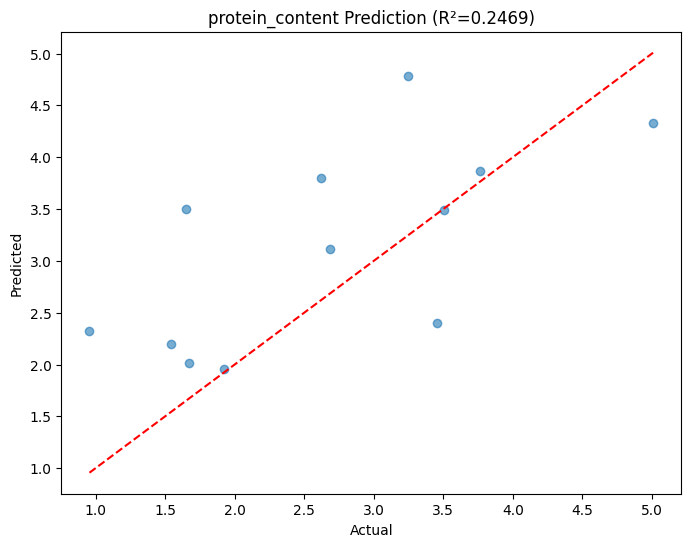

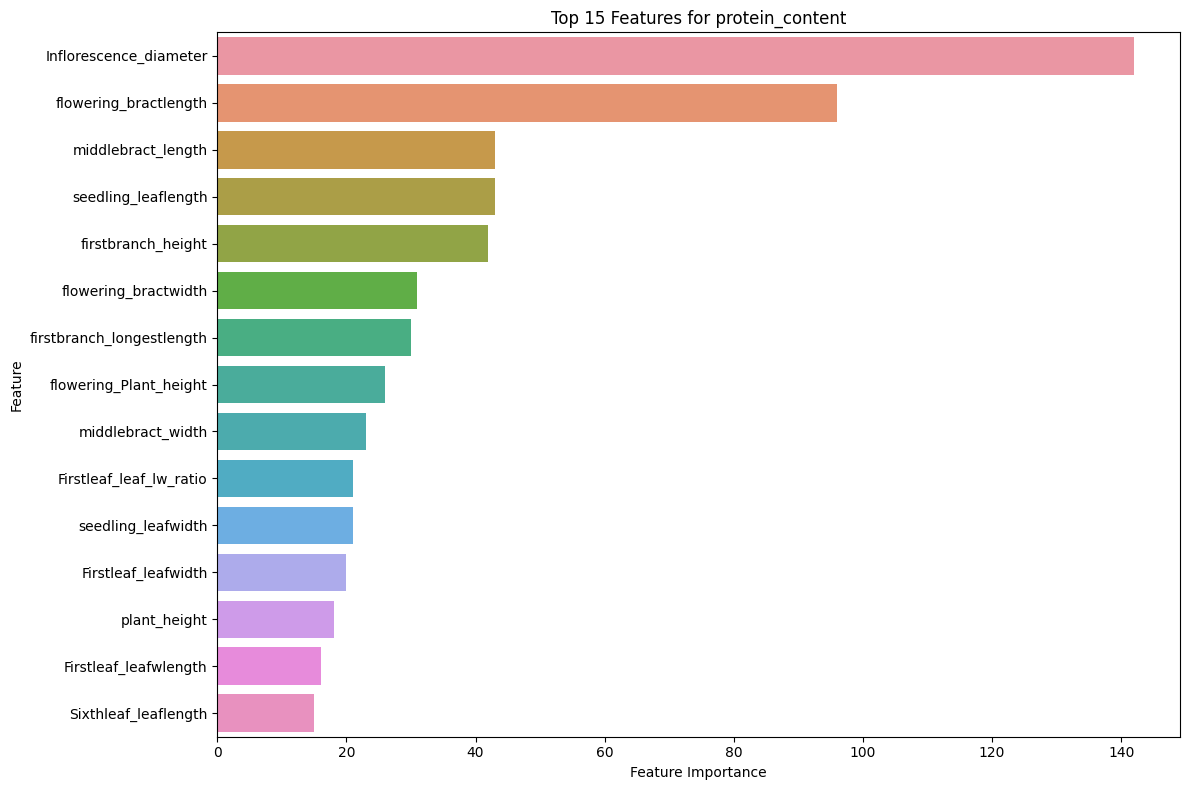

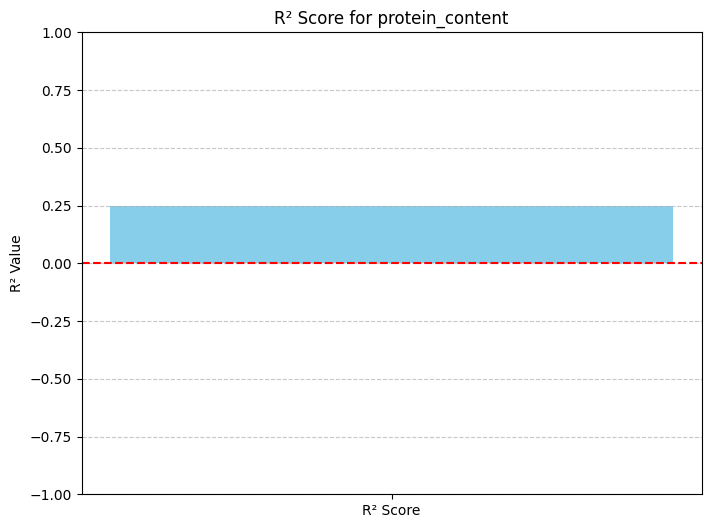


训练完成: protein_content
测试R²: 0.2469
模型已保存为: model_protein_content.joblib
预处理器已保存为: preprocessor_protein_content.joblib
预测图已保存为: prediction_protein_content.png
特征重要性图已保存为: feature_importance_protein_content.png
R²值图已保存为: r2_score_protein_content.png


In [4]:
# ==== 配置参数 ====
FEATURE_NAME = "protein_content"  # 特征名称:Crude_fiber,fat,alpha_Linolenic_acid,protein_content,Ca,K,Na,Mg,Fe,Zn,Cu,SS
MERGE_FEATURES_PATH = 'merge_features.csv'
MERGED_DATA_PATH = 'merged_data.csv'

if __name__ == "__main__":
    print(f"开始训练特征: {FEATURE_NAME}")
    
    # 加载数据
    X, y, target_features = load_and_preprocess_data(MERGE_FEATURES_PATH, MERGED_DATA_PATH)
    
    # 检查特征是否存在
    if FEATURE_NAME not in target_features:
        print(f"错误: 特征 '{FEATURE_NAME}' 不在目标特征列表中")
        print(f"可用特征: {', '.join(target_features)}")
        exit(1)
    
    # 训练模型
    result = train_model_for_feature(X, y, FEATURE_NAME)
    
    if result:
        print(f"\n训练完成: {FEATURE_NAME}")
        print(f"测试R²: {result['test_r2']:.4f}")
        print(f"模型已保存为: model_{FEATURE_NAME}.joblib")
        print(f"预处理器已保存为: preprocessor_{FEATURE_NAME}.joblib")
        print(f"预测图已保存为: prediction_{FEATURE_NAME}.png")
        print(f"特征重要性图已保存为: feature_importance_{FEATURE_NAME}.png")
        print(f"R²值图已保存为: r2_score_{FEATURE_NAME}.png")
    else:
        print(f"训练失败: {FEATURE_NAME}")